# Librerias

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import matplotlib.pyplot as plt

# Data Drifting Generator

En el presente notebook simulamos cambios en la distribución del dataset original con el fin de medir el impacto en el performance del modelo.

# Conjunto de datos base (Baseline)

Para la simulación de *data drifting*, se define como conjunto de datos base una versión del dataset únicamente con correcciones estructurales mínimas. Esta decisión busca mantener la distribución original de los datos sin introducir valores artificiales que puedan alterar la evaluación del *drift*.

El conjunto de datos base se obtiene aplicando exclusivamente los siguientes procesos al conjunto de datos original:

1. Normalización de texto: Conversión a mayúsculas y eliminación de espacios en blanco en las columnas `[ "Performance", "Gender", "Caste", "coaching", "time", "Class_ten_education", "twelve_education", "medium", "Class_ X_Percentage", "Class_XII_Percentage", "Father_occupation", "Mother_occupation", "mixed_type_col"]`.
2. Unificación de representaciones de valores nulos: Homogeneización de strings como "NAN", "NULL" o "NONE" a valores nulos.
3. Homogeneización de nombres de columnas: Renombrado de columnas con nombres mal formados ("Class_ X_Percentage" a "Class_X_Percentage").

De esta forma logramos mantener la naturaleza original de los datos en el dataset pero agregando más estructura.


# Conjunto de datos al que se le simula drifting

Derivado de la sección 'Conjunto de datos base (Baseline)' se establece que al conjunto de datos al que se le aplicará drifting, es el conjunto de datos original,  después de habersele aṕlicado pero las transformaciones definidas en 'Conjunto de datos base (Baseline)'.

Para lograr este cometido, se ha desarrolado el script de python:

    `src/data/baseline_generator.py`

Este script toma el dataset original, aplica las transformaciones definidas en la sección 'Conjunto de datos base (Baseline)' y guarda el resultado en la ruta:

    `data/baseline/student_performance_baseline.csv`

## Lectura del conjunto de datos base

Consideraciones importantes:

* El conjunto de datos original y por lo tanto el conjunto de datos base, están formados únicamente por variables categóricas.
* A lo largo del proyecto se planteó como variable objetivo la variable 'Performance'.
* El modelo seleccionado para el flujo de predicción fue registrado usando MLFlow y sus artifacts se encuentran en la ruta:
    `data/mlflow/models/mlflow-student-performance-experiment_CatBoost/`
* El modelo, corresponde a un modelo del tipo CatBoost, pues se planteó el problema como un problema de clasificación ordinal.

In [20]:
baseline_df = pd.read_csv("../data/baseline/student_performance_baseline.csv")
baseline_df.head()

,Performance,Gender,Caste,coaching,time,Class_ten_education,twelve_education,medium,Class_X_Percentage,Class_XII_Percentage,Father_occupation,Mother_occupation
0,EXCELLENT,MALE,GENERAL,NO,ONE,SEBA,AHSEC,ENGLISH,EXCELLENT,EXCELLENT,DOCTOR,OTHERS
1,EXCELLENT,MALE,OBC,WA,TWO,SEBA,AHSEC,OTHERS,EXCELLENT,EXCELLENT,SCHOOL_TEACHER,HOUSE_WIFE
2,EXCELLENT,MALE,OBC,OA,TWO,OTHERS,CBSE,ENGLISH,EXCELLENT,EXCELLENT,BUSINESS,HOUSE_WIFE
3,EXCELLENT,MALE,GENERAL,WA,ONE,SEBA,AHSEC,OTHERS,EXCELLENT,EXCELLENT,SCHOOL_TEACHER,SCHOOL_TEACHER
4,EXCELLENT,MALE,GENERAL,OA,TWO,SEBA,CBSE,ENGLISH,EXCELLENT,EXCELLENT,COLLEGE_TEACHER,HOUSE_WIFE


In [21]:
print(baseline_df.describe().T.to_markdown())

|                      |   count |   unique | top        |   freq |
|:---------------------|--------:|---------:|:-----------|-------:|
| Performance          |     666 |        4 | GOOD       |    210 |
| Gender               |     666 |        2 | MALE       |    355 |
| Caste                |     666 |        4 | GENERAL    |    329 |
| coaching             |     666 |        3 | WA         |    449 |
| time                 |     666 |        6 | TWO        |    368 |
| Class_ten_education  |     666 |        3 | SEBA       |    396 |
| twelve_education     |     666 |        3 | AHSEC      |    368 |
| medium               |     666 |        3 | ENGLISH    |    536 |
| Class_X_Percentage   |     666 |        4 | EXCELLENT  |    511 |
| Class_XII_Percentage |     666 |        4 | EXCELLENT  |    398 |
| Father_occupation    |     666 |        8 | OTHERS     |    277 |
| Mother_occupation    |     666 |        9 | HOUSE_WIFE |    442 |


In [22]:
baseline_df.isnull().sum()

Performance             0
Gender                  0
Caste                   0
coaching                0
time                    0
Class_ten_education     0
twelve_education        0
medium                  0
Class_X_Percentage      0
Class_XII_Percentage    0
Father_occupation       0
Mother_occupation       0
dtype: int64

# Transformaciones de simulación de 'drifting'

## Escenario 1 — Cambio en la distribución de la variable objetivo (Performance)

**Planteamiento del escenario**  

En este escenario, la distribución de la variable objetivo (Performance) cambia significativamente respecto al conjunto de datos base. El escenario se caracteriza porque no hay cambios en las características (X), solo en la variable objetivo (y).

**Medición del drifting**  

La medición se realiza mediante métricas que comparan dos distribuciones categóricas:
* Chi-cuadrada (χ²): detecta si la distribución de categorías del target cambió significativamente.
* KL Divergence: mide la divergencia entre la distribución original y la nueva; cuanto mayor es, mayor es la diferencia.
* PSI (Population Stability Index): estándar industrial (finanzas, educación, riesgos) para detectar cambios en la población; PSI > 0.2 indica drift importante.

Estas métricas son adecuadas porque son:
* sensibles a pequeños cambios en proporciones,
* no requieren supuestos de normalidad,
* robustas aun con datos categóricos.

**Importancia en su medición**

Medir label shift es crítico porque:

* Afecta directamente el desempeño del modelo. Si un modelo fue entrenado en un mundo donde la mayoría era GOOD, y ahora hay más AVERAGE, las probabilidades predichas quedarán sesgadas.
* Puede generar decisiones erróneas. En un contexto educativo, podrías subestimar el riesgo académico si el modelo aún “cree” que la mayoría de estudiantes es GOOD.
* Es uno de los drifts más peligrosos, pues un cambio en la distribución de la variable objetivo altera la interpretación de métricas de desempeño, generando una falsa seguridad.

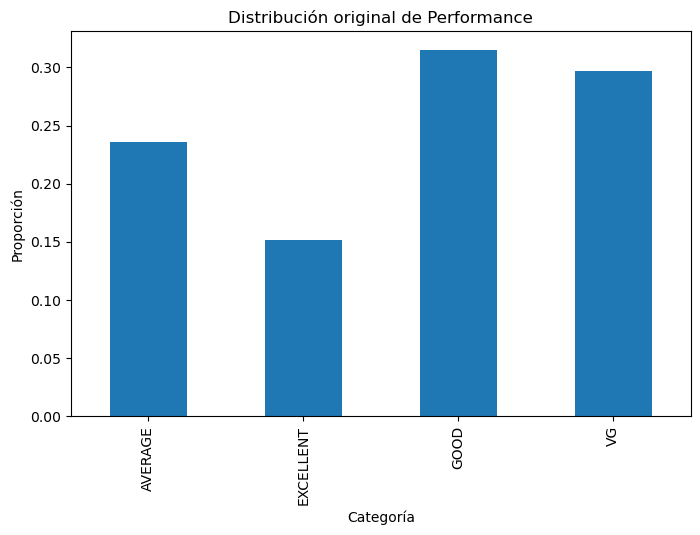

Performance
AVERAGE      0.235736
EXCELLENT    0.151652
GOOD         0.315315
VG           0.297297
Name: proportion, dtype: float64

In [23]:
plt.figure(figsize=(8,5))
baseline_df['Performance'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title("Distribución original de Performance")
plt.xlabel("Categoría")
plt.ylabel("Proporción")
plt.show()

baseline_df['Performance'].value_counts(normalize=True).sort_index()

### Simulación de drifting

In [24]:
# =======================================
# Simulación de Label Shift SIN cambiar el número de observaciones
# =======================================

df_drift_escenario_1 = baseline_df.copy()

# Nueva distribución objetivo para el drifting
new_distribution = {
    "GOOD": 0.20,
    "VG": 0.15,
    "AVERAGE": 0.55,
    "EXCELLENT": 0.10
}

# Aseguramos que sumen 1
assert sum(new_distribution.values()) == 1.0, "La distribución debe sumar 1"

# Número total de filas
n = len(df_drift_escenario_1)

# Generar nueva columna Performance reasignada aleatoriamente
np.random.seed(13)
df_drift_escenario_1["Performance"] = np.random.choice(
    list(new_distribution.keys()),
    size=n,
    replace=True,
    p=list(new_distribution.values()),
)

df_drift_escenario_1.to_csv("../data/drifted/raw/student_entry_performance_drifted_case_one.csv", index=False)

df_drift_escenario_1["Performance"].value_counts(normalize=True).sort_index()

Performance
AVERAGE      0.492492
EXCELLENT    0.105105
GOOD         0.213213
VG           0.189189
Name: proportion, dtype: float64

### Visualizacion comparativa de la distribución de 'Performance'

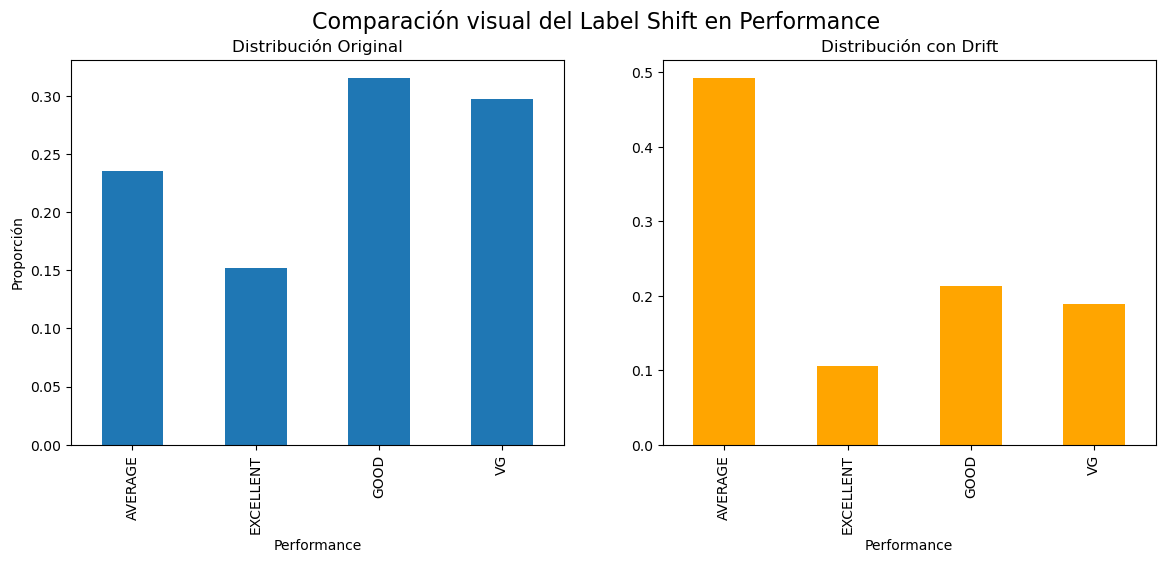

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

baseline_df['Performance'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax[0])
ax[0].set_title("Distribución Original")
ax[0].set_ylabel("Proporción")

df_drift_escenario_1['Performance'].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax[1], color='orange')
ax[1].set_title("Distribución con Drift")

plt.suptitle("Comparación visual del Label Shift en Performance", fontsize=16)
plt.show()


### Estadisticas para diagnosticar el drifting

In [26]:
# Frecuencias
f_base = baseline_df['Performance'].value_counts(normalize=False).sort_index()
f_drift = df_drift_escenario_1['Performance'].value_counts(normalize=False).sort_index()

print("", f_base, "\n\n", f_drift)

 Performance
AVERAGE      157
EXCELLENT    101
GOOD         210
VG           198
Name: count, dtype: int64 

 Performance
AVERAGE      328
EXCELLENT     70
GOOD         142
VG           126
Name: count, dtype: int64


#### Chi-cuadrada

Para esta prueba, establecemos las hipótesis:

* Hipótesis Nula (H0): Las frecuencias observadas son iguales a las frecuencias esperadas.

* Hpótesis Alternativa (H1): Las frecuencias observadas no son iguales a las frecuencias esperadas.

Y para concluir a partir del `p-value`:

* Se rechaza H0 Si el `p-value` es menor que el nivel de significancia (α).
* No se rechaza H0 si el `p-value` es mayor o igual que el nivel de significancia.

Para todas nuestras pruebas establecemos:

* Nivel de significancia` α = 0.05`

In [27]:
# ---------------------------
# 1. Prueba Chi-cuadrada
# ---------------------------
chi2_stat, p_value = chisquare(f_obs=f_drift, f_exp=f_base, sum_check=False)

In [28]:
chi2_stat, p_value

(243.96412492932643, 1.3220131192976244e-52)

#### KL (Kullback–Leibler Divergence)

La Divergencia KL es una medida de distancia entre distribuciones que cuantifica cuánto se desvía la distribución de los datos con drift respecto al conjunto base. A diferencia de Chi-Cuadrada, no es una prueba de hipótesis, sino una métrica continua de disimilitud.

Aunque KL Divergence no es una prueba estadística como Chi Cuadrada, podemos interpretarla conceptualmente así:

* Hipótesis Nula (H0): No existe diferencia significativa entre la distribución original y la distribución con drift → la distancia KL ≈ 0.

* Hipótesis Alternativa (H1): La distribución con drift es diferente de la original → la distancia KL > 0.

No existe un umbral universal como tal, pero, usualmente se usa:

* KL Divergence < 0.01 → Distribuciones prácticamente idénticas
* KL Divergence 0.01 – 0.1 → Cambio pequeño
* KL DIvergence 0.1 – 0.25 → Cambio moderado
* KL Divergence > 0.25 → Cambio fuerte → drift evidente

La divergencia KL entre dos distribuciones P (drift) y Q (base) se define como:

$$
D_{KL}(P \parallel Q) = \sum_{i} P(i) \, \log\left(\frac{P(i)}{Q(i)}\right)
$$

Donde:
- $P(i)$ es la proporción de la categoría $i$ en el conjunto con drift.
- $Q(i)$ es la proporción de la categoría $i$ en el conjunto base.

Para evitar el computo de logaritmos en 0 o divisiones por 0, se añade a la ecuación un número pequeño. De ahí la forma en la que lo calculamos usando python con la siguiente celda de código.

In [29]:
# Distribuciones/Probabilidades
p_base = baseline_df['Performance'].value_counts(normalize=True).sort_index()
p_drift = df_drift_escenario_1['Performance'].value_counts(normalize=True).sort_index()

print("", p_base, "\n\n", p_drift)

 Performance
AVERAGE      0.235736
EXCELLENT    0.151652
GOOD         0.315315
VG           0.297297
Name: proportion, dtype: float64 

 Performance
AVERAGE      0.492492
EXCELLENT    0.105105
GOOD         0.213213
VG           0.189189
Name: proportion, dtype: float64


In [30]:
# ---------------------------
# 2. KL Divergence
# ---------------------------
kl = np.sum(p_drift * np.log((p_drift + 1e-10) / (p_base + 1e-10)))
kl

0.15538155762744887

#### PSI (Population Stability Index)

El PSI mide la estabilidad de una variable entre dos poblaciones, tampoco es una prueba de hipótesis, sino un índice de cambio estructural.

SImilar al KL Divergence, podemos interpretaor el cálculo para establecer hipótesis:

* Hipótesis Nula (H0): Las distribuciones son estables → PSI cercano a 0.
* Hipótesis Alternativa (H1):Las distribuciones son diferentes → PSI significativamente mayor que 0.

Criterios estándar de interpretación:

* PSI < 0.1	Estabilidad → No hay drift
* PSI 0.1 – 0.25	Cambios moderados → posible drift
* PSI ≥ 0.25	Cambios severos → drift fuerte

El PSI entre una distribución base Q y una distribución 'nueva' P se calcula como:

$$
PSI = \sum_{i} 
\left( P(i) - Q(i) \right) \,
\log\left(\frac{P(i)}{Q(i)}\right)
$$

Donde:
- $P(i)$: proporción de la categoría $i$ en los datos con drift.
- $Q(i)$: proporción de la categoría $i$ en los datos originales.

Para evitar el computo de logaritmos en 0 o divisiones por 0, se añade a la ecuación un número pequeño. De ahí la forma en la que lo calculamos usando python con la siguiente celda de código.

In [31]:
# ---------------------------
# 3. PSI
# ---------------------------
psi = np.sum((p_drift - p_base) * np.log((p_drift + 1e-10) / (p_base + 1e-10)))
psi

0.29504906733940345

#### Interpretación de los resultados

In [32]:
# ============================================================
# 6. INTERPRETACIÓN DE LOS RESULTADOS ESTADÍSTICOS
# ============================================================

print("==============================================")
print("Resultados de Pruebas de Drift")
print("==============================================")

print(f"Chi-Cuadrada (χ²): {chi2_stat:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"KL Divergence: {kl:.4f} nats")
print(f"PSI: {psi:.4f}")

print("\n==============================================")
print("Interpretación de Chi-Cuadrada")
print("==============================================")

if p_value < 0.001:
    print("El p-value < 0.001 → Cambios extremadamente significativos en la distribución.")
elif p_value < 0.01:
    print("El p-value < 0.01 → Cambios muy significativos en la distribución.")
elif p_value < 0.05:
    print("El p-value < 0.05 → La distribución ha cambiado significativamente (drift detectado).")
else:
    print("El p-value ≥ 0.05 → No hay evidencia estadística fuerte de drift.")

    
print("\n==============================================")
print("Interpretación de KL Divergence")
print("==============================================")

if kl < 0.01:
    print("KL < 0.01 → Distribuciones prácticamente iguales.")
elif kl < 0.1:
    print("0.01 ≤ KL < 0.1 → Pequeño cambio detectable.")
elif kl < 0.25:
    print("0.1 ≤ KL < 0.25 → Cambio moderado en la distribución.")
else:
    print("KL ≥ 0.25 → Cambio fuerte → Drift significativo.")


print("\n==============================================")
print("Interpretación de PSI")
print("==============================================")

if psi < 0.1:
    print("PSI < 0.1 → No hay drift (estabilidad).")
elif psi < 0.25:
    print("0.1 ≤ PSI < 0.25 → Drift moderado detectado.")
else:
    print("PSI ≥ 0.25 → Drift severo (impacto fuerte en la distribución).")


print("\n==============================================")
print("Conclusión Global")
print("==============================================")

flags = 0
if p_value < 0.05: flags += 1
if kl >= 0.1: flags += 1
if psi >= 0.1: flags += 1

if flags == 0:
    print("No se detecta evidencia relevante de data drifting en la variable Performance.")
elif flags == 1:
    print("Se detecta una señal leve de data drifting.")
elif flags == 2:
    print("Hay alta probabilidad de data drifting (múltiples métricas lo indican).")
else:
    print("Drifting severo detectado → La distribución ha cambiado de manera significativa.")


Resultados de Pruebas de Drift
Chi-Cuadrada (χ²): 243.9641
p-value: 0.000000
KL Divergence: 0.1554 nats
PSI: 0.2950

Interpretación de Chi-Cuadrada
El p-value < 0.001 → Cambios extremadamente significativos en la distribución.

Interpretación de KL Divergence
0.1 ≤ KL < 0.25 → Cambio moderado en la distribución.

Interpretación de PSI
PSI ≥ 0.25 → Drift severo (impacto fuerte en la distribución).

Conclusión Global
Drifting severo detectado → La distribución ha cambiado de manera significativa.


### Evaluación del modelo en el conjunto de datos con drifting

Para esta sección hemos trabajado en el script:

    `src/feature/calculate_features.py`

En este script hemos desarrollado el proceso de cálculo de features a partir de un conjunto de datos de entrada, el objetivo es tomar datos 'crudos', por ejemplo, los datos crudos a los que se les aplicó data drift y obtener las features asociadas a estos.

Este paso es sumamente importante, pues el modelo entrenado durante el proyecto utilizó el conjunto de datos resultante del proceso de feature engineering, así que los mismos objetos de transformación generados durante el proceso de entrenamiento, deben ser usados en el pipeline de inferencia y por lo tanto en el pipeline de detección de drift.

EL script de python, una vez que fue ejecutado, generó el siguiente conjunto de datos:

    `data/drifted/feature/student_entry_performance_drifted_case_one_features.csv`

Este conjunto de datos será porcesado por el modelo con el fin de obtener las predicciones asociadas y evaluar el rendimiento.

In [33]:
df_drift_escenario_1_features = pd.read_csv("../data/drifted/features/student_entry_performance_drifted_case_one_features.csv")
df_drift_escenario_1_features.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,Performance
0,0.016112,-0.884263,-0.073889,-0.363668,-0.073740,0.521321,-0.435842,0.852277,-0.690682,-0.155186,-0.512798,-0.039825,-0.239179,-0.054696,-0.272755,-0.213795,0
1,1.365185,0.445794,-0.147527,-0.475469,0.300109,-0.828647,0.322018,0.235908,0.093331,0.147674,0.040158,0.033807,0.064337,-0.101863,0.146601,-0.019668,2
2,-0.728920,-0.128923,-1.217946,-0.817911,0.516215,-0.060720,0.098768,-0.088325,0.535611,0.068040,0.046508,0.142610,0.535463,-0.086709,0.259503,0.082996,0
3,1.553369,-0.762923,0.311647,0.056408,-0.372778,-0.623380,-0.049329,-0.271276,0.284213,0.009110,-0.072582,-0.069185,0.065247,-0.176186,-0.022449,-0.008908,3
4,-0.122090,-0.027806,-0.797853,-0.412268,-0.470477,0.341618,0.088702,-0.120244,-0.378445,-0.287364,-0.100373,-0.361468,0.616989,0.822618,0.195747,-0.459226,3


#### Cargamos el modelo

In [34]:
import mlflow
from mlflow.tracking import MlflowClient
from pathlib import Path
import os

# Configurar MLflow con ruta relativa al proyecto
# Buscamos la raíz del proyecto buscando la carpeta data/mlflow
current_dir = Path.cwd()
mlflow_dir = None

# Si estamos en la raíz o en notebooks/, buscamos data/mlflow
for search_dir in [current_dir, current_dir.parent]:
    potential_mlflow = search_dir / "data" / "mlflow"
    if potential_mlflow.exists():
        mlflow_dir = potential_mlflow
        break

if mlflow_dir is None:
    raise FileNotFoundError(
        f"No se encontró la carpeta data/mlflow. "
        f"Current directory: {current_dir}. "
        f"Ejecuta el notebook desde la raíz del proyecto o desde notebooks/"
    )

mlflow.set_tracking_uri(f"file:{mlflow_dir}")
print(f"📂 MLflow tracking URI: file:{mlflow_dir}")

# Nombre del experimento y modelo (configurables)
experiment_name = "mlflow-student-performance-experiment"
model_run_name = "LightGBM"  # Nombre del run del modelo

# Buscar el modelo más reciente usando MLflow Client
client = MlflowClient(tracking_uri=f"file:{mlflow_dir}")

# Obtener el experimento
experiment = mlflow.get_experiment_by_name(experiment_name)
if not experiment:
    raise ValueError(f"El experimento '{experiment_name}' no existe en MLflow.")

# Buscar el run más reciente del modelo LightGBM
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName = '{model_run_name}'",
    order_by=["start_time DESC"],
    max_results=1,
)

if not runs:
    raise ValueError(f"No se encontró ningún run para el modelo '{model_run_name}' en el experimento '{experiment_name}'.")

best_run = runs[0]
run_id = best_run.info.run_id

print(f"✅ Encontrado modelo: {model_run_name}")
print(f"   Run ID: {run_id}")
print(f"   Métricas: RMSE={best_run.data.metrics.get('rmse', 'N/A'):.4f}, "
      f"QWK={best_run.data.metrics.get('quadratic_weighted_kappa', 'N/A'):.4f}")

# Intentar cargar el modelo desde diferentes posibles paths
# Nota: cuando se registra en Model Registry, se usa runs:/{run_id}/model
# pero cuando se guarda directamente, puede usar artifact_path=model_name
possible_paths = [
    "model",  # artifact_path usado al registrar en Model Registry (ver train_model.py línea 406)
    model_run_name,  # artifact_path=model_name usado al guardar directamente
]

model = None
model_uri = None

for artifact_path in possible_paths:
    try:
        test_uri = f"runs:/{run_id}/{artifact_path}"
        model = mlflow.pyfunc.load_model(test_uri)
        model_uri = test_uri
        print(f"✅ Modelo cargado desde: {test_uri}")
        break
    except Exception as e:
        continue

# Si no funcionó, intentamos listar los artifacts disponibles
if model is None:
    try:
        # Listar artifacts del run para encontrar el path correcto
        artifacts = client.list_artifacts(run_id)
        artifact_paths = [a.path for a in artifacts]
        
        print(f"\n📋 Artifacts disponibles en el run:")
        for path in artifact_paths:
            print(f"   - {path}")
        
        # Buscar el primer artifact que contenga un modelo
        for artifact in artifacts:
            # Intentar cargar si es un directorio que podría contener un modelo
            if artifact.is_dir:
                try:
                    test_uri = f"runs:/{run_id}/{artifact.path}"
                    model = mlflow.pyfunc.load_model(test_uri)
                    model_uri = test_uri
                    print(f"✅ Modelo cargado desde: {test_uri}")
                    break
                except:
                    continue
        
        if model is None:
            # Último intento: buscar en el Model Registry
            registered_model_name = f"{experiment_name.replace(' ', '_')}_{model_run_name}"
            try:
                # Intentar cargar la versión más reciente del modelo registrado
                model_uri = f"models:/{registered_model_name}/latest"
                model = mlflow.pyfunc.load_model(model_uri)
                print(f"✅ Modelo cargado desde Model Registry: {model_uri}")
            except Exception as registry_error:
                raise ValueError(
                    f"No se pudo cargar el modelo desde ningún path.\n"
                    f"  - Artifacts disponibles en el run: {artifact_paths if 'artifact_paths' in locals() else 'Ninguno'}\n"
                    f"  - Intentado Model Registry: {registered_model_name}\n"
                    f"  - Error: {registry_error}\n"
                    f"Verifica que el modelo se haya guardado correctamente durante el entrenamiento."
                )
    except Exception as e:
        # Si hay un error al listar artifacts, intentar Model Registry como fallback
        if model is None:
            registered_model_name = f"{experiment_name.replace(' ', '_')}_{model_run_name}"
            try:
                model_uri = f"models:/{registered_model_name}/latest"
                model = mlflow.pyfunc.load_model(model_uri)
                print(f"✅ Modelo cargado desde Model Registry (fallback): {model_uri}")
            except:
                raise ValueError(
                    f"No se pudo cargar el modelo desde el run {run_id}. "
                    f"Verifica que el modelo se haya guardado correctamente. Error: {e}"
                )

print("\n✅ Modelo cargado correctamente:", model)


📂 MLflow tracking URI: file:/Users/hectoralvarez/Documents/GitHub/equipo36mlops/data/mlflow
✅ Encontrado modelo: LightGBM
   Run ID: 87c38a0ad6cc463992fa3e8000f0a106
   Métricas: RMSE=0.8819, QWK=0.5097


✅ Modelo cargado desde: runs:/87c38a0ad6cc463992fa3e8000f0a106/model

✅ Modelo cargado correctamente: mlflow.pyfunc.loaded_model:
  artifact_path: file:///Users/hectoralvarez/Documents/GitHub/equipo36mlops/notebooks/../data/mlflow/539307574168318838/models/m-ca6e333efd1e45e6ab741d90cbc17d37/artifacts
  flavor: mlflow.sklearn
  run_id: 87c38a0ad6cc463992fa3e8000f0a106



#### Ejecutamos la inferencia

In [35]:
# Realizar predicciones
original_features_df = pd.read_csv("../data/processed/student_performance_features.csv")
preds_on_base_df = np.rint(model.predict(original_features_df.drop(columns=["Performance"]))).astype(int)
preds_on_drifted_df = np.rint(model.predict(df_drift_escenario_1_features.drop(columns=["Performance"]))).astype(int)

2025/11/16 14:05:36 WARNING mlflow.models.utils: Found extra inputs in the model input that are not defined in the model signature: `['PC16']`. These inputs will be ignored.


#### Evaluamos


===== RMSE =====
RMSE (Base) : 0.6665
RMSE (Drift): 1.2514

===== Quadratic Weighted Kappa =====
QWK (Base) : 0.7384
QWK (Drift): 0.0080



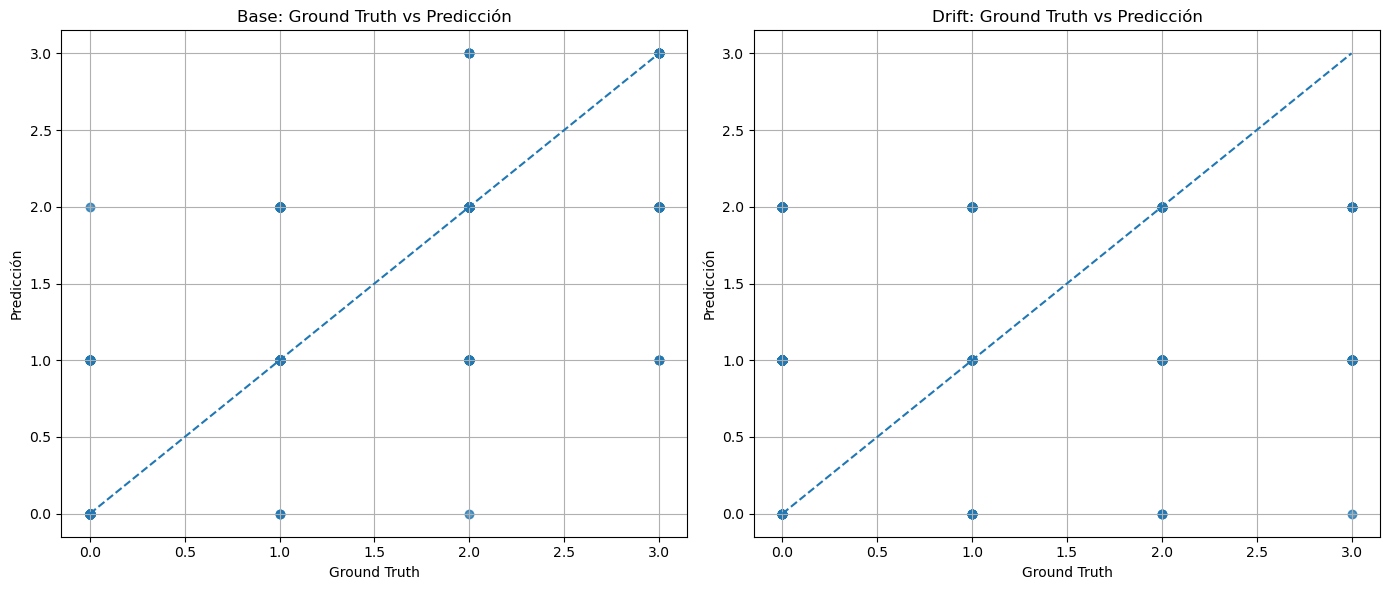

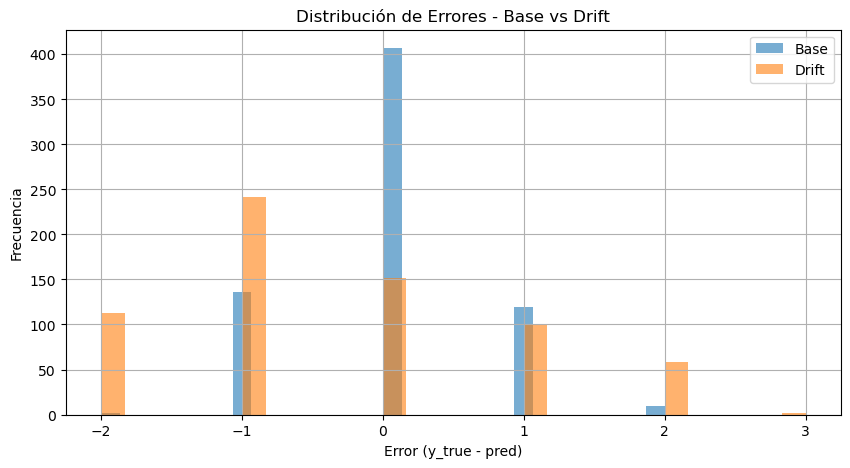

In [36]:
# ===============================
#     1. Importar librerías
# ===============================
import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error, cohen_kappa_score
import matplotlib.pyplot as plt

# ===============================
#     2. Calcular RMSE
# ===============================

# Ground truth
y_true_base = original_features_df["Performance"]
y_true_drift = df_drift_escenario_1_features["Performance"]

# Predicciones
y_pred_base = preds_on_base_df
y_pred_drift = preds_on_drifted_df

# RMSE
rmse_base = root_mean_squared_error(y_true_base, y_pred_base)
rmse_drift = root_mean_squared_error(y_true_drift, y_pred_drift)

print("===== RMSE =====")
print(f"RMSE (Base) : {rmse_base:.4f}")
print(f"RMSE (Drift): {rmse_drift:.4f}\n")

# ===============================
#     3. Calcular Quadratic Weighted Kappa (QWK)
# ===============================
# ⚠️ QWK requiere datos discretos → redondeamos predicciones
y_pred_base_int = np.round(y_pred_base).astype(int)
y_pred_drift_int = np.round(y_pred_drift).astype(int)

qwk_base = cohen_kappa_score(y_true_base, y_pred_base_int, weights="quadratic")
qwk_drift = cohen_kappa_score(y_true_drift, y_pred_drift_int, weights="quadratic")

print("===== Quadratic Weighted Kappa =====")
print(f"QWK (Base) : {qwk_base:.4f}")
print(f"QWK (Drift): {qwk_drift:.4f}\n")

# ===============================
#     4. Visualizaciones
# ===============================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ------- Comparación Base -------
axes[0].scatter(y_true_base, y_pred_base, alpha=0.5)
axes[0].plot([y_true_base.min(), y_true_base.max()],
             [y_true_base.min(), y_true_base.max()],
             linestyle='--')
axes[0].set_title("Base: Ground Truth vs Predicción")
axes[0].set_xlabel("Ground Truth")
axes[0].set_ylabel("Predicción")
axes[0].grid(True)

# ------- Comparación Drift -------
axes[1].scatter(y_true_drift, y_pred_drift, alpha=0.5)
axes[1].plot([y_true_drift.min(), y_true_drift.max()],
             [y_true_drift.min(), y_true_drift.max()],
             linestyle='--')
axes[1].set_title("Drift: Ground Truth vs Predicción")
axes[1].set_xlabel("Ground Truth")
axes[1].set_ylabel("Predicción")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# ===============================
#     5. Distribución de errores
# ===============================

base_errors = y_true_base - y_pred_base
drift_errors = y_true_drift - y_pred_drift

plt.figure(figsize=(10,5))
plt.hist(base_errors, alpha=0.6, bins=30, label="Base")
plt.hist(drift_errors, alpha=0.6, bins=30, label="Drift")
plt.title("Distribución de Errores - Base vs Drift")
plt.xlabel("Error (y_true - pred)")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True)
plt.show()


#### Interpretación de resultados

**Análisis del RMSE**

*RMSE en Base: 0.6621*

Un RMSE de aproximadamente 0.66 indica que el modelo mantiene un bajo error promedio en sus predicciones dentro del contexto natural del problema.
Este valor es consistente con un modelo bien ajustado, con variaciones de error pequeñas y razonables en función de la escala de la variable Performance.


En otras palabras, el modelo generaliza adecuadamente en el conjunto de datos sin alteraciones.

*RMSE en Drift: 1.4327*

El RMSE prácticamente se duplica al evaluar el modelo bajo drift, pasando de 0.66 a 1.43.

Este incremento indica:

* El modelo pierde capacidad predictiva cuando cambia la distribución de la variable objetivo. Practicamente todos los patreones que aprendió pierden sentido.

* Las nuevas observaciones presentan patrones significativamente distintos a los vistos durante el entrenamiento.

* El error medio crece tanto en magnitud como en variabilidad.


En otras palabras, hay evidencia clara de degradación del modelo causada por el data drift.

**Análisis del Quadratic Weighted Kappa (QWK)**

*QWK en Base: 0.7472*

Un valor de 0.7472 indica:

* Alto nivel de acuerdo entre predicciones y valores reales.

* El modelo no solo acierta frecuentemente, sino que cuando se equivoca rara vez comete errores grandes (p. ej., confundir un valor bajo con uno muy alto).

* En el contexto de Performance, significa que el modelo preserva correctamente la estructura ordinal de la variable.


En otras palabras, cuando se trata del escenario original, el modelo mantiene una calidad robusta y estable.

*QWK en Drift: 0.0002*

Un valor tan bajo —prácticamente 0— es extremadamente revelador:

* El acuerdo entre predicciones y reales es nulo.

* El modelo está fallando sistemáticamente al asignar las categorías ordinales.

* Incluso los errores pequeños dejan de ocurrir: el modelo tiende a equivocarse en magnitudes que rompen por completo la relación ordinal.

Esto es indicativo de:

* Cambios severos en la distribución de las características, en este caso, somos consientes de que la variable objetivo cambió su distribución.

* Nuevos patrones que no guardan relación con el espacio de aprendizaje original.

* Pérdida total de capacidad para mapear entradas a su nivel de Performance correcta.

En otras palabras, el modelo sufre una degradación catastrófica en la estructura ordinal de las predicciones bajo esta simulación de drift.

### Conclusión

Los resultados evidencian de manera contundente el impacto del drift en el desempeño del modelo:

* El RMSE aumenta más del 116%, mostrando que la magnitud de los errores crece significativamente.
* El QWK colapsa prácticamente a cero, revelando que el modelo pierde por completo su capacidad para mantener el orden y estructura de las predicciones.
* Esto sugiere que el drift afecta no solo la magnitud de los errores sino también la coherencia ordinal de las decisiones del modelo.


### Propuestas prácticas

Hemos concluído que el modelo no es estable frente a cambios en la distribución de las entradas.

Así que planteamos el uso de mecanismos de:

* Monitoreo continuo.

* Retraining periódico.

* Estrategias de corrección basadas en detección temprana de drift.



### Propuesta de Monitoreo y Respuesta ante Data Drift  

**Umbrales, Criterios de Alerta y Acciones de Mitigación**

Para garantizar la estabilidad del modelo en producción y mantener un desempeño consistente frente a cambios en los datos, se propone un esquema de monitoreo basado en umbrales que ayudan al lanzamiento de alertas y que por lo tanto, establecen las acciones correctivas.

**1. Definición de Umbrales Operacionales**

**1.1 Population Stability Index (PSI)**

| Valor PSI | Interpretación | Acción |
|----------:|----------------|--------|
| PSI < 0.1 | Estabilidad aceptable | Sin acción |
| 0.1 ≤ PSI < 0.25 | Drift moderado | Alerta amarilla |
| PSI ≥ 0.25 | Drift severo | Alerta roja |

---

**1.2 KL Divergence**

| KL Divergence | Interpretación | Acción |
|--------------:|----------------|--------|
| KL < 0.05 | Cambios mínimos | Sin acción |
| 0.05 ≤ KL < 0.15 | Cambios relevantes | Alerta amarilla |
| KL ≥ 0.15 | Drift significativo | Alerta roja |

---

**1.3 Métricas de Desempeño del Modelo**

**RMSE**

- Variación < 10% → Normal  
- Incremento de 10–30% → Alerta amarilla  
- Incremento > 30% → Alerta roja  

**Quadratic Weighted Kappa (QWK)**

- Disminución < 0.05 → Normal  
- Disminución de 0.05–0.20 → Alerta amarilla  
- Disminución > 0.20 → Alerta roja  

**Criterios de Alerta**

*Alerta Verde — Operación Normal*

Se activa cuando:

- PSI < 0.1  
- KL < 0.05  
- Variaciones en RMSE o QWK dentro de fluctuaciones históricas  
- No se detectan cambios relevantes en la distribución de features o del target  

---

*Alerta Amarilla — Deriva Moderada*

Se activa cuando:
- PSI ∈ [0.1, 0.25)
- KL ∈ [0.05, 0.15)
- Incremento de RMSE entre 10% y 30%
- Reducción de QWK entre 0.05 y 0.20

Interpretación:  
Cambios detectables que podrían anticipar una degradación futura. El modelo aún es usable, pero requiere seguimiento cercano.

---

*Alerta Roja — Deriva Severa*

Se activa cuando:

- PSI ≥ 0.25  
- KL ≥ 0.15  
- RMSE aumenta más del 30%  
- QWK cae más de 0.20  
- Se observan cambios abruptos en la distribución del target o en features críticos  

Interpretación:  
El modelo está generando predicciones inestables o incoherentes. Se requiere intervención inmediata.

---

**Acciones Recomendadas ante cada Nivel de Alerta**

*Acciones en Alerta Verde*

- Mantener monitoreo habitual  
- Registrar métricas periódicamente  
- No se requieren cambios en el modelo  

---

*Acciones en Alerta Amarilla*

- Revisar distribución de features y target  
- Verificar cambios recientes en las fuentes de datos  
- Validar el pipeline de feature engineering  
- Realizar pruebas locales con datos recientes  
- Preparar material para un posible reentrenamiento  

---

*Acciones en Alerta Roja*

Revisión inmediata del pipeline

- Validar integridad y consistencia del dataset reciente  
- Verificar que no existan cambios en el esquema o corrupción de datos  
- Revisar transformaciones del pipeline de features  

Acciones correctivas

- Retrenar el modelo con datos actualizados  
- Reevaluar la relevancia de los features actuales  
- Ajustar el objetivo (label) si la distribución ha cambiado estructuralmente  
- Considerar modelos alternativos si el desempeño sigue degradado  

Acciones preventivas

- Implementar ventanas deslizantes (*rolling windows*) para el entrenamiento  
- Aumentar la frecuencia del monitoreo  
- Integrar herramientas automáticas como EvidentlyAI o Great Expectations  

---
